# Jitter Fisher Analysis

Telescope jitter will negatively effect an inference algorithm's ability to constrain all its other parameters. In the case of the TOLIMAN telescope, we are primarily concerned with the ability to constrain the binary separation. In this notebook we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters.

First let's configure the notebook.

In [3]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
import jax
from tqdm.notebook import tqdm

from detector_layers import ApplyAsymmetricJitter

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
# plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

## Building Model
Here we build our dLux forwards model with parametric jitter.

In [4]:
pscale = .375  # arcsec/pixel
det_npix = 128
oversample = 4
wf_npixels = 512
kernel_size = 40
jitter_params = {"r": 0.01, "phi": 0, "shear": 0}

In [5]:
src = dlT.AlphaCen()
osys = dlT.TolimanOptics(wf_npixels=512, psf_pixel_scale=pscale, psf_oversample=oversample, psf_npixels=det_npix*oversample)
det = dl.LayeredDetector([
    (ApplyAsymmetricJitter(**jitter_params, kernel_size=kernel_size), 'Jitter'),
    (dl.IntegerDownsample(oversample), 'Downsample'),
])

telescope = dl.Instrument(sources=src, optics=osys, detector=det)

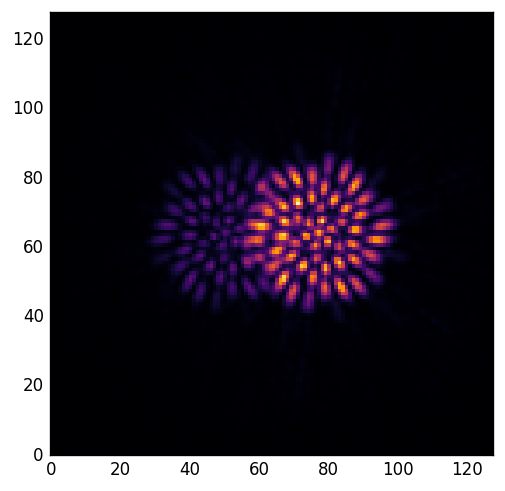

In [6]:
plt.imshow(telescope.model())
# plt.savefig('figs/jitter_diagram.png', dpi=300, bbox_inches='tight')

## Fisher Analysis
Now we will perform a Fisher analysis to determine the effect of jitter on the ability to constrain these parameters. We will do this by calculating the covariance matrix of the parameters of interest. We will then plot the standard deviation of each parameter as a function of the jitter magnitude.

In [7]:
# Marginal params
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
]
# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike)

# Bar sizes
rs = np.linspace(0.01, 1.2, 8)
shears = np.array([0, 0.2, 0.5, 0.95])
phis = np.array([0, 45, 75, 90, 105, 135, 180])

covs, seps, pas, xs, ys, fluxes, conts = [], [], [], [], [], [], []

# sep_array = numpy.zeros((len(shears), len(phis), len(rs)))
for r_idx, r in tqdm(enumerate(rs), total=len(rs)):
    # Set mask width
    model = telescope.set("detector.Jitter.r", r)
    
    for shear_idx, shear in enumerate(shears):
        # Set mask width
        model = model.set("detector.Jitter.shear", shear)
        
        for phi_idx, phi in enumerate(phis):
            # Set mask width
            model = model.set("detector.Jitter.phi", phi)
            
            # Calculate covariance matrix and standard deviations
            cov = calc_cov(model, params)        
            covs.append(cov)
        
            stds = np.sqrt(np.diag(np.abs(cov)))
        
            # Save values
            seps.append(stds[0])
            pas.append(stds[1])
            xs.append(stds[2])
            ys.append(stds[3])
            fluxes.append(stds[4])
            conts.append(stds[5])
        
seps = np.array(seps).reshape(len(rs), len(shears), len(phis))
pas = np.array(pas).reshape(len(rs), len(shears), len(phis))
xs = np.array(xs).reshape(len(rs), len(shears), len(phis))
ys = np.array(ys).reshape(len(rs), len(shears), len(phis))
fluxes = np.array(fluxes).reshape(len(rs), len(shears), len(phis))
conts = np.array(conts).reshape(len(rs), len(shears), len(phis))

# covs = np.array(covs).
# ents = vmap(zdx.covaraince_entropy)(covs)

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plotting
Now we will plot the standard deviation of each parameter as a function of the jitter magnitude. We will plot the standard deviation for each shear value on a separate axis.

In [ ]:
def plot_param_std(parameter, rs, phis, shears, param_name: str = None):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    
    for shear_idx, row, col in zip(range(4), [0, 0, 1, 1], [0, 1, 0, 1]):
    
        ax[row][col].plot(rs, parameter[:, shear_idx, :], label=phis)
        ax[row][col].axhline(0., linestyle='-', color='k')
        ax[row][col].set(
            title=param_name + f': Shear = {shears[shear_idx]}',
            xlabel='Jitter Magnitude [pix?]',
            ylabel=f'StDev of {param_name} [?]',
            xlim=(rs.min(), rs.max()),
            ylim=(0, None)
        )
        ax[row][col].legend()
        ax[row][col].grid(True, alpha=0.5, linestyle='--')
    plt.savefig('figs/jitter_analysis.pdf')
    plt.show()

In [ ]:
plot_param_std(seps, rs, phis, shears, param_name='Separation')
plot_param_std(pas, rs, phis, shears, param_name='Position Angle')
plot_param_std(xs, rs, phis, shears, param_name='X Position')
plot_param_std(ys, rs, phis, shears, param_name='Y Position')
plot_param_std(fluxes, rs, phis, shears, param_name='Flux')
plot_param_std(conts, rs, phis, shears, param_name='Contrast')